# Mini Project: Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore CliffWalkingEnv

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [7]:
import gym
env = gym.make('CliffWalking-v0')

In [8]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

Rui's Note:

The cliff states have state values of 0. I think becuse once agent steps into cliff, the next_state is returned as start point, so the cliff states are never returned as next_state and thus their state value never got a chance to be updated and remain as initial value 0.

/Users/rui/env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


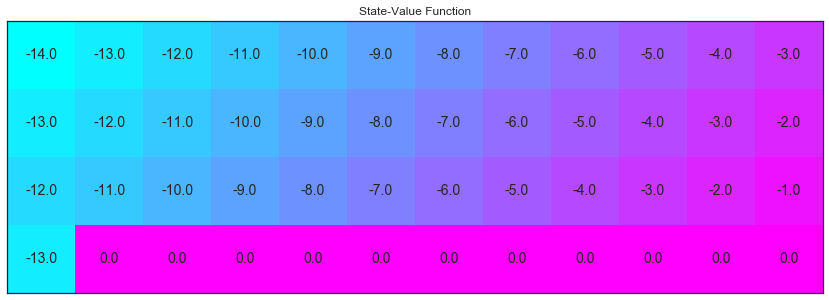

In [9]:
import numpy as np
from plot_utils import plot_values

# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

In [10]:
V_opt

array([[-14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,
         -3.],
       [-13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,
         -2.],
       [-12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,
         -1.],
       [-13.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]])

### Part 1: TD Prediction: State Values

In this section, you will write your own implementation of TD prediction (for estimating the state-value function).

We will begin by investigating a policy where the agent moves:
- `RIGHT` in states `0` through `10`, inclusive,  
- `DOWN` in states `11`, `23`, and `35`, and
- `UP` in states `12` through `22`, inclusive, states `24` through `34`, inclusive, and state `36`.

The policy is specified and printed below.  Note that states where the agent does not choose an action have been marked with `-1`.

In [11]:
policy = np.hstack([1*np.ones(11), 2, 0, np.zeros(10), 2, 0, np.zeros(10), 2, 0, -1*np.ones(11)])
print("\nPolicy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy.reshape(4,12))


Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.]
 [ 0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]


Run the next cell to visualize the state-value function that corresponds to this policy.  Make sure that you take the time to understand why this is the corresponding value function!

Rui's Note:

These state value function can be calculated by V(t) = R(t+1) + gamma * V(t+1)

/Users/rui/env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


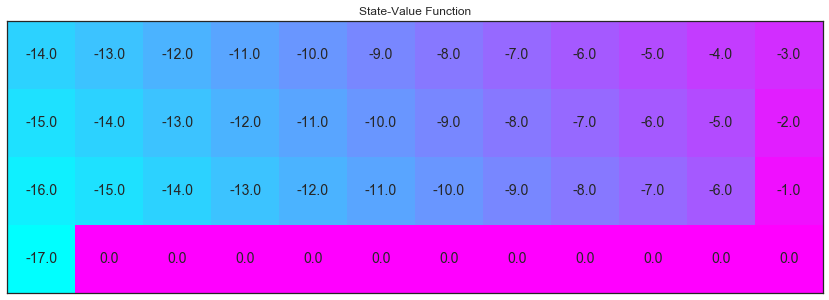

In [12]:
V_true = np.zeros((4,12))
for i in range(3):
#     V_true[0:12][i] = -np.arange(3, 15)[::-1] - i
    V_true[i, 0:12] = -np.arange(3, 15)[::-1] - i    
V_true[1][11] = -2
V_true[2][11] = -1
V_true[3][0] = -17

plot_values(V_true)

The above figure is what you will try to approximate through the TD prediction algorithm.

Your algorithm for TD prediction has five arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `policy`: This is a 1D numpy array with `policy.shape` equal to the number of states (`env.nS`).  `policy[s]` returns the action that the agent chooses when in state `s`.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a dictionary where `V[s]` is the estimated value of state `s`.

Please complete the function in the code cell below.

In [13]:
from collections import defaultdict, deque
import sys

def td_prediction(env, num_episodes, policy, alpha, gamma=1.0):
    # initialize empty dictionaries of floats
    V = defaultdict(float)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        # NOTE: env.reset() always return state 36, the starting point
        state = env.reset()  
#         print('episode', i_episode, 'state', state)
        t = 0
        while True:
            action = policy[state]            
            next_state, reward, done, info = env.step(action)
            V[state] = V[state] + alpha * (reward + gamma * V[next_state] - V[state])
            state = next_state
            t += 1            
            if done:
                break
        
    return V 

Run the code cell below to test your implementation and visualize the estimated state-value function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

**<span style="color: green;">PASSED</span>**

/Users/rui/env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


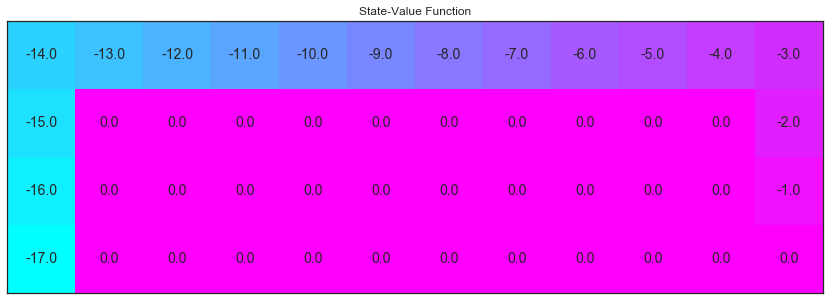

In [14]:
import check_test

# evaluate the policy and reshape the state-value function
V_pred = td_prediction(env, 5000, policy, .01)

# please do not change the code below this line
V_pred_plot = np.reshape([V_pred[key] if key in V_pred else 0 for key in np.arange(48)], (4,12)) 
check_test.run_check('td_prediction_check', V_pred_plot)
plot_values(V_pred_plot)

How close is your estimated state-value function to the true state-value function corresponding to the policy?  

**You might notice that some of the state values are not estimated by the agent.  This is because under this policy, the agent will not visit all of the states.  In the TD prediction algorithm, the agent can only estimate the values corresponding to states that are visited.**

### Part 2: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [ ]:
def epsilon_greedy_for_state(env, q_state, epsilon):
    # NOTE: set default action for unseen state
#     total_num_actions = env.action_space.n
#     policy = defaultdict(lambda: np.random.choice(np.arange(total_num_actions)))
    policy = defaultdict(lambda: env.action_space.sample())    
    
    for state, action_values in Q.items():
        num_actions = len(action_values)        
        avg_action_prob = float(epsilon) / num_actions
        greedy_action_prob = 1 - epsilon + avg_action_prob                
        
        action_probs = avg_action_prob * np.ones(num_actions)
        
        max_action_idx = np.argmax(action_values)        
        action_probs[max_action_idx] = greedy_action_prob
                
        action = np.random.choice(np.arange(num_actions), p=action_probs)        
        policy[state] = action    
    
#     print('policy', policy)        
    return policy        

In [60]:
def epsilon_greedy_pick_state_action(env, action_values, epsilon):
    num_actions = len(action_values)      
    
    avg_action_prob = float(epsilon) / num_actions
    action_probs = avg_action_prob * np.ones(num_actions)

    max_action_idx = np.argmax(action_values)            
    greedy_action_prob = 1 - epsilon + avg_action_prob                
    action_probs[max_action_idx] = greedy_action_prob

    action = np.random.choice(np.arange(num_actions), p=action_probs)               
    return action

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    # initialize performance monitor
    reward_list = []    
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1 == 0:  # if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
                
        ## TODO: complete the function       
        expected_cumulative_reward = 0        
        
        # Test 1:
        epsilon = 1.0 / i_episode
        # Test 2:
#         epsilon = 1.0 / ((i_episode/8000)+1) 
        
        # NOTE: env.reset() always return state 36, the starting point
        state = env.reset()         
        action = epsilon_greedy_pick_state_action(env, Q[state], epsilon)        
                  
        t = 0
        while True:      
#             print('episode', i_episode, 't', t, 'state', state, 'action', action)
            next_state, reward, done, info = env.step(action)
            next_action = epsilon_greedy_pick_state_action(env, Q[next_state], epsilon)                    
            
            Q[state][action] = Q[state][action] + alpha * (
                reward + gamma * Q[next_state][next_action] - Q[state][action]
            )
        
            state = next_state
            action = next_action            
            expected_cumulative_reward += reward            
            t += 1            
            if done:
                reward_list.append(expected_cumulative_reward)
                break

#     print('reward_list', reward_list)
    plt.plot(range(1, num_episodes + 1), reward_list)                
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

### Test 1: epsilon = 1.0 / i_episode

Episode 5000/5000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  2  2  0  2  2  0  1  2  1  2]
 [ 3  1  2  2  1  1  3  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


/Users/rui/env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


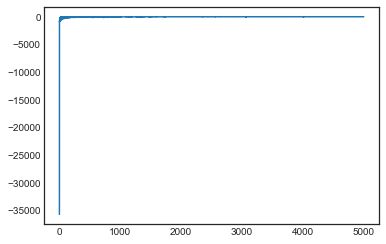

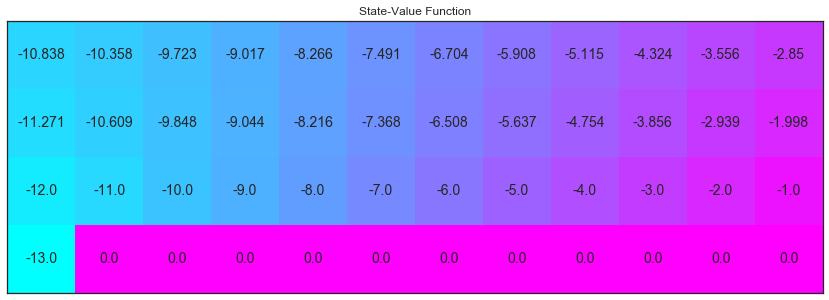

In [62]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

In [63]:
Q_sarsa

defaultdict(<function __main__.sarsa.<locals>.<lambda>>,
            {0: array([-10.84613465, -10.83779428, -10.84486854, -10.85029627]),
             1: array([-10.36965745, -10.35777597, -10.36123118, -10.36722415]),
             2: array([-9.73682371, -9.72499909, -9.72302841, -9.72496613]),
             3: array([-9.02949245, -9.0181074 , -9.01664493, -9.0200788 ]),
             4: array([-8.26623244, -8.26744718, -8.2745019 , -8.27848513]),
             5: array([-7.5102789 , -7.49324757, -7.49125177, -7.50007024]),
             6: array([-6.70496458, -6.70567436, -6.70403685, -6.71242202]),
             7: array([-5.9079116 , -5.90990807, -5.91290819, -5.92011071]),
             8: array([-5.1309732 , -5.11464989, -5.11644388, -5.11702604]),
             9: array([-4.33320474, -4.32550465, -4.32383309, -4.33928022]),
             10: array([-3.55666656, -3.55616215, -3.556335  , -3.56529044]),
             11: array([-2.85834815, -2.85023484, -2.85000415, -2.8551869 ]),
         

### Test 2: epsilon = 1.0 / ((i_episode/8000)+1) 

Episode 5000/5000

**<span style="color: red;">PLEASE TRY AGAIN</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0  0  0  0  0  0  0  1  1  1  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


/Users/rui/env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


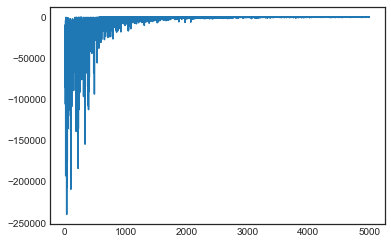

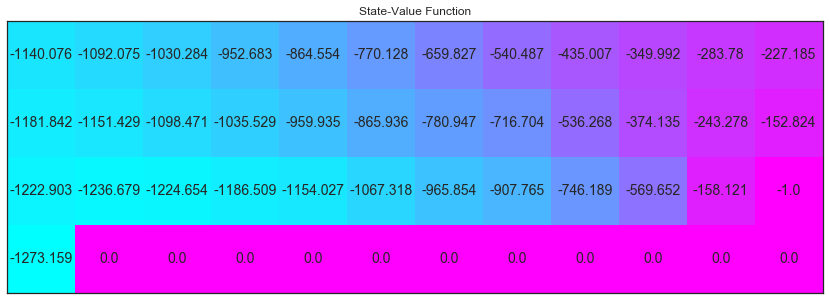

In [54]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

In [55]:
Q_sarsa

defaultdict(<function __main__.sarsa.<locals>.<lambda>>,
            {0: array([-1201.17674033, -1140.07572589, -1239.76710827, -1199.96332905]),
             1: array([-1153.90808927, -1092.07513124, -1232.68091832, -1198.90433022]),
             2: array([-1104.65356614, -1030.28426776, -1196.99020875, -1165.32395212]),
             3: array([-1025.58760349,  -952.68253745, -1137.8350969 , -1100.31749588]),
             4: array([ -951.65752771,  -864.55393091, -1084.35345958, -1039.85029508]),
             5: array([ -878.93500058,  -770.12789165, -1014.07653379,  -958.71393854]),
             6: array([-765.07852343, -659.82674291, -922.09992296, -877.66470354]),
             7: array([-687.85220115, -540.48661822, -878.05101929, -780.03344994]),
             8: array([-584.31537537, -435.00678611, -718.4226689 , -689.80801735]),
             9: array([-482.85424584, -349.9916207 , -543.66104534, -586.67083213]),
             10: array([-367.77452007, -283.78005629, -380.57207023, 

### Part 3: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [ ]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

In [ ]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 4: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [ ]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

In [ ]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])